<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/kmeans_deep_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How it differs from the default solution? 

More smaller patches and denser patches extraction from images.

    PATCH_SIZE = 4
    patch_num  = 5000000
    STRIDE     = 2
    
Also, more clustsers:

    kroot = 16
    k = kroot * kroot
    
Note that it takes significant time to execute all steps

# Load data & default imports

In [32]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import scipy.stats as sstats
import multiprocessing as mp
from sklearn import datasets
import sklearn.linear_model
from tqdm.auto import tqdm
from matplotlib import animation, pyplot, rc
import matplotlib.pyplot as plt
import httpimport
from os.path import join
import os.path
from PIL import Image

In [6]:
!pip install -q gdown httpimport
![ -e cifar.npz ] || gdown 'https://drive.google.com/uc?id=1oBzZdtg2zNTPGhbRy6DQ_wrf5L5OAhNR' -O cifar.npz

In [7]:
with np.load('cifar.npz') as data:
    cifar_train_data = data['train_data']
    cifar_train_labels = data['train_labels']
    cifar_test_data = data['test_data']
    cifar_test_labels = data['test_labels']


def exists(file_path):
    return os.path.isfile(file_path)

In [8]:
X_trn = cifar_train_data
y_trn = cifar_train_labels
X_tst = cifar_test_data
y_tst = cifar_test_labels

# Deep Features

## find important patterns in patches

In [9]:
PATCH_SIZE = 4
patch_num  = 100000
STRIDE     = 2

kroot = 16
k = kroot **2

In [10]:
def contrast(image):
    return (image-image.min())/(image.max() - image.min())

def normalize_patch(patch, eps=10):
    return (patch - patch.mean())/np.sqrt(patch.var() + eps)

def whiten(X):
    X_norm = (X - X.mean(axis=0))/X.std(axis=0)
    cov = np.cov(X_norm, rowvar=False) 
    U,S,V = np.linalg.svd(cov)

    X_zca = U.dot(np.diag(1.0/np.sqrt(S + 0.1))).dot(U.T).dot(X_norm.T).T
    return X_zca

In [11]:
def run_cached(fun, data, name):
    if exists(join('cache', f'{name}')):
        print (f"Found cached {name}, load it ? ")
        flag = input()
        if flag == 'y':
            with open(join('cache', f'{name}'), 'rb') as f:
                res = pickle.load(f)
        else:
            res = fun(data)
    else:
        res = fun(data)
        
    with open(join('cache', f'{name}'), 'wb') as f:
        pickle.dump(res, f)
    return res    

In [12]:
def extract_patches(data):
    patches = []
    reshaped = data.reshape(-1,32,32,3)
    n = int(patch_num / (32-PATCH_SIZE+1) ** 2 + 1)
    for i in tqdm(range(n)):
        for r in range(32-PATCH_SIZE+1):
            for c in range(32-PATCH_SIZE+1):
                patch = reshaped[i][c:(c+PATCH_SIZE),r:(r+PATCH_SIZE)].flatten()
                patch_norm = normalize_patch(patch, eps=10)
                patches.append(patch_norm)

    P = np.vstack(patches)
    return whiten(P)

P_zca = run_cached(extract_patches, X_trn, 'P_zca')

Found cached P_zca, load it ? 


 n


  0%|          | 0/119 [00:00<?, ?it/s]

# Clusters

In [13]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np

def centroids(data):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0, verbose=True, n_init=1, max_iter=200, batch_size=10000)
    kmeans.fit(data)
    return kmeans.cluster_centers_

filters_final = run_cached(centroids, P_zca, 'kmeans')

Found cached kmeans, load it ? 


 n


Init 1/1 with method k-means++
Inertia for init 1/1: 464293.31214837474
[MiniBatchKMeans] Reassigning 9 cluster centers.
Minibatch step 1/2001: mean batch inertia: 15.289827925229824
[MiniBatchKMeans] Reassigning 5 cluster centers.
Minibatch step 2/2001: mean batch inertia: 13.727605240846321, ewa inertia: 13.727605240846321
[MiniBatchKMeans] Reassigning 2 cluster centers.
Minibatch step 3/2001: mean batch inertia: 13.380226780000829, ewa inertia: 13.658185084802058
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch step 4/2001: mean batch inertia: 13.386212753282651, ewa inertia: 13.60383409928659
Minibatch step 5/2001: mean batch inertia: 13.501033655608396, ewa inertia: 13.583290445474002
Minibatch step 6/2001: mean batch inertia: 13.220816082861106, ewa inertia: 13.51085352248981
Minibatch step 7/2001: mean batch inertia: 13.114141724618827, ewa inertia: 13.431574586064755
Minibatch step 8/2001: mean batch inertia: 13.122075001881795, ewa inertia: 13.369724149577355
Minibat

# Some intuition what the patches are

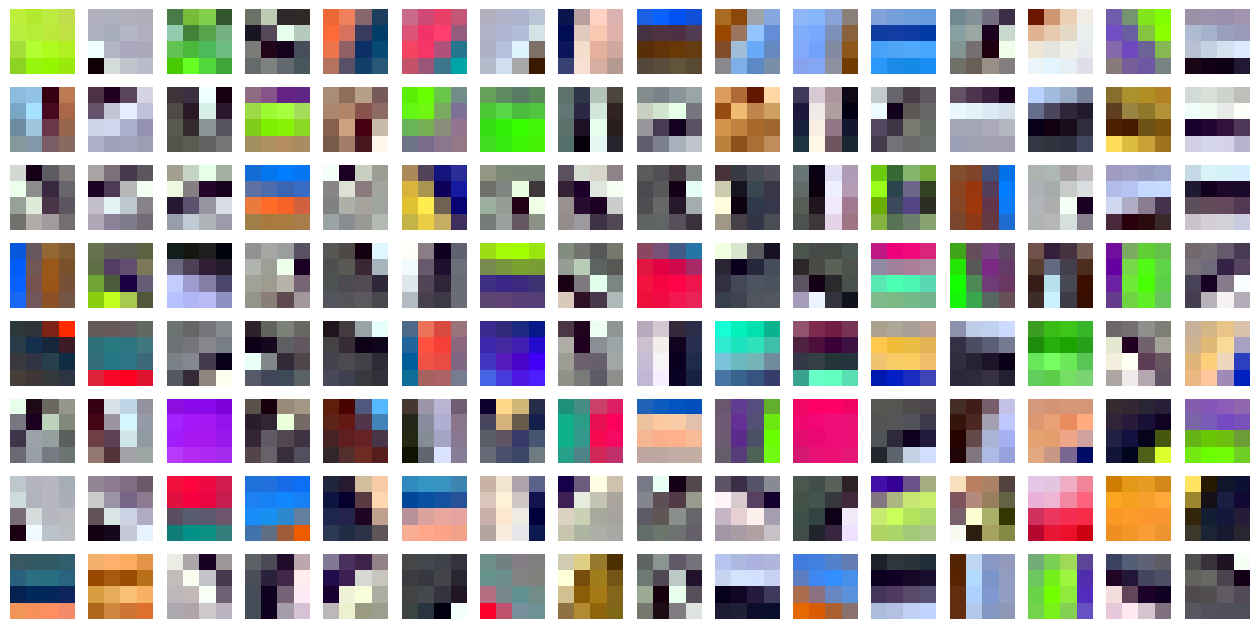

In [14]:
plt.figure(figsize=(kroot,kroot))
for xx in range(128):
    plt.subplot(kroot,kroot,xx+1)
    plt.imshow((contrast(filters_final[xx])).reshape(PATCH_SIZE, PATCH_SIZE, 3))
    plt.axis('off')

# Transform dataset according to the patterns found in patches




In [15]:
def dist(x,y):
    return np.sqrt((x - y).dot(x-y))

def create_patch_features(X):    
    X_mapped_list_per_image = []
    for i in tqdm(range(X.shape[0])):
        mapped_features = []
        for r in range(0, 32-PATCH_SIZE+1, STRIDE):
            for c in range(0, 32-PATCH_SIZE+1, STRIDE):
                patch = X[i].reshape(32,32,3)[c:(c+PATCH_SIZE),r:(r+PATCH_SIZE)].flatten()
                patch_norm = normalize_patch(patch, eps=0.01)
                mapped_features.append([dist(patch_norm, f) for f in filters_final])
        X_mapped_list_per_image.append(np.vstack(mapped_features))
    X_mapped = np.asarray(X_mapped_list_per_image).reshape(-1, ((32-PATCH_SIZE)//STRIDE+1)**2*filters_final.shape[0])
    return X_mapped


In [16]:
from sklearn.feature_extraction import image
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

def create_patch_features__vectorized(X):    
    X_mapped_list_per_image = []
    for i in tqdm(range(X.shape[0])):
        patches = image.extract_patches_2d(X[i], (PATCH_SIZE, PATCH_SIZE))
        strided_patches = patches.reshape( 32-PATCH_SIZE+1 , 32-PATCH_SIZE+1, PATCH_SIZE, PATCH_SIZE, 3)[::STRIDE,::STRIDE,:,:,:]
        strided_patches = strided_patches.reshape(((32-PATCH_SIZE)//STRIDE+1)**2, PATCH_SIZE * PATCH_SIZE * 3)
        mapped_features = euclidean_distances(np.asarray([normalize_patch(patch, eps=0.01) for patch in strided_patches]), filters_final)
        X_mapped_list_per_image.append(mapped_features.reshape(((32-PATCH_SIZE)//STRIDE+1)**2 * filters_final.shape[0]))
    X_mapped = np.asarray(X_mapped_list_per_image)
    return X_mapped

In [17]:
X_mapped_trn = run_cached(create_patch_features__vectorized, X_trn, 'X_mapped_trn')

Found cached X_mapped_trn, load it ? 


 n


  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
X_mapped_tst = run_cached(create_patch_features__vectorized, X_tst, 'X_mapped_tst')

Found cached X_mapped_tst, load it ? 


 n


  0%|          | 0/10000 [00:00<?, ?it/s]

# Logistic Regression on mapped features

In [ ]:
def normalize(data):
    return (data - data.mean(axis=0))/data.std(axis=0)

In [ ]:
#X_mapped_trn_norm = run_cached(normalize, X_mapped_trn, "X_mapped_trn_norm")
#X_mapped_tst_norm = run_cached(normalize, X_mapped_tst, "X_mapped_tst_norm")
X_mapped_trn_norm = normalize(X_mapped_trn)
X_mapped_tst_norm = normalize(X_mapped_trn)

In [ ]:
from sklearn.linear_model import LogisticRegression

def logreg(data):
    x, y = data
    clf = LogisticRegression(random_state=0, max_iter=100, n_jobs=-1, verbose=True)
    clf.fit(x, y.flatten())
    return clf

clf = run_cached(logreg, (X_mapped_trn_norm, y_trn), 'logreg')

Found cached logreg, load it ? 


 n


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       576010     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15129D+05    |proj g|=  5.10920D+03


 This problem is unconstrained.



At iterate   50    f=  5.56773D+04    |proj g|=  8.15650D+02


# Results! 😊

In [ ]:
y_trn_pred = clf.predict(X_mapped_trn_norm)
print(f"Train: {(y_trn.flatten() == y_trn_pred).mean()}")

y_tst_pred = clf.predict(X_mapped_tst_norm)
print(f"Test:  {(y_tst.flatten() == y_tst_pred).mean()}")
